In [1]:
import numpy as np
import pandas as pd
import scraps as scr
import pickle
import pygtc
import pprint as pp
import numpy as np
from matplotlib import pyplot as plt
import csv
    
try: import simplejson as json
except ImportError: import json

class ScrapsWrapper:
    def __init__(self):
        return
    
    def pkl_to_s2p(self,pkl_file,s2p_file):
        pkl = pickle.load(open(pkl_file,'rb'))

        with open(s2p_file, 'w') as f:
            writer = csv.writer(f, delimiter='\t')
            writer.writerow(["Frequency", "I", "Q"])
            writer.writerows(zip(pkl.freq,pkl.ch1.values,pkl.ch2.values))

    def process_file(self,fileName, mask = None, meta_only=False, **loadtxt_kwargs):
        """Load Keysight PNA file data into dict."""
        #Find the temperature, power, and name locations from the filename
        tempLoc = fileName.find('TEMP') + 5
        pwrLoc = fileName.find('DBM') - 4

        splitname = str.split(str.split(fileName,'_')[0],'/')
        if len(splitname) > 1:
            splitrm = [splitname.remove(splitname[0]) for i in range(2)]

        resNameLoc = fileName.find(splitname[0])

        if mask is None:
            mask = slice(None, None)
        else:
            assert type(mask) == slice, "mask must be of type slice."

        #Read the temp, pwr, and resName from the filename
        if(fileName[tempLoc + 1] == '.'):
            temp = np.float(fileName[tempLoc:tempLoc+5])

            if fileName[pwrLoc] == '_':
                pwr = np.float(fileName[pwrLoc+1:pwrLoc+3])
            else:
                pwr = np.float(fileName[pwrLoc:pwrLoc+3])

            resName = fileName[resNameLoc:resNameLoc+len(splitname[0])]

            metaDict = {'name':resName,'temp':temp,'pwr':pwr}

            if meta_only:
                dataDict = {}
            else:
                #Grab frequency, I, and Q
                fileData = np.loadtxt(fileName, **loadtxt_kwargs)
                freqData = fileData[:,0][mask]
                IData = fileData[:,1][mask]
                QData = fileData[:,2][mask]

                dataDict = {'freq':freqData,'I':IData,'Q':QData}

            retVal = {}
            retVal.update(metaDict)
            retVal.update(dataDict)

            return retVal
        else:

            assert False, "Bad file? " + fileName
            
    def resonator_objects(self,fileDataDict):
        #Create a resonator object using the helper tool
        resObj1 = scr.makeResFromData(fileDataDict)

        #Create a resonator object using the helper tool and also fit the data
        #To do this, we pass a function that initializes the parameters for the fit, and also the fit function
        resObj2 = scr.makeResFromData(fileDataDict, paramsFn = scr.cmplxIQ_params, fitFn = scr.cmplxIQ_fit)

        #Check the temperature and power
        print('Temperature = ', resObj1.temp)
        print('Power = ', resObj1.pwr)

        #Check to see whether a results object exists
        print('Do fit results exist for the first object? ', resObj1.hasFit)
        print('Do fit results exist for the second object? ', resObj2.hasFit)


        #Explicitly call the fitter on the first object.
        #Here we will call it, and also override the guess for coupling Q with our own quess
        resObj1.load_params(scr.cmplxIQ_params)
        resObj1.do_lmfit(scr.cmplxIQ_fit, qc=5000)

        #Check to see whether a results object exists again, now they are both True
        print('Do fit results exist for the first object? ', resObj1.hasFit)
        print('Do fit results exist for the second object? ', resObj2.hasFit)

        #Compare the best guess for the resonant frequency (minimum of the curve) to the actual fit
        #Because we didn't specify a label for our fit, the results are stored in the lmfit_result
        #dict under the 'default' key. If we passed the optional label argument to the do_lmfit
        #method, it would store the results under whatever string is assigned to label.
        print('Guess = ', resObj2.fmin, ' Hz')
        print('Best fit = ', resObj2.lmfit_result['default']['result'].params['f0'].value, ' Hz')
        print('Best fit with different qc guess = ',
              resObj1.lmfit_result['default']['result'].params['f0'].value, ' Hz')

        #You can see the fit is not terribly sensitive to the guess for qc.
        return resObj1,resObj2
    
    def plot_ResListData(self,resObj):

        #When using inline plotting, you have to assign the output of the plotting functions to a figure, or it will plot twice

        #This function takes a list of resonators. It can handle a single one, just need to pass it as a list:
        figA = scr.plotResListData([resObj],
            plot_types = ['LogMag', 'Phase'], #Make two plots
            num_cols = 2, #Number of columns
            fig_size = 6, #Size in inches of each subplot
            show_colorbar = False, #Don't need a colorbar with just one trace
            force_square = True, #If you love square plots, this is for you!
            plot_fits = [True]*2) #Overlay the best fit, need to specify for each of the plot_types
        
    def do_emcee(self,resObj):
    
        #Call the emcee hook and pass it the fit function that calculates your residual.
        #Since we already ran a fit, emcee will use that fit for its starting guesses.
        resObj.do_emcee(scr.cmplxIQ_fit, nwalkers = 30, steps = 1000, burn=200)

        #Check to see that a emcee result exists
        print('Does an emcee chain exist? ', resObj.hasChain)

        #Look at the first few rows of the output chain:
        chains = resObj.emcee_result['default']['result'].flatchain

        print('\nHead of chains:')
        pp.pprint(chains.head())

        #Compare withe the mle values (percent difference):
        #Maximum liklihood estimates (MLE) are stored in Resonator.mle_vals
        #lmfit best fit values for varied parameters are in Resonator.lmfit_vals
        diffs = list(zip(resObj.mle_labels, (resObj.mle_vals - resObj.lmfit_vals)*100/resObj.lmfit_vals))

        print('\nPerecent difference:')
        pp.pprint(diffs)

        return chains

    def plot_gtc(self,resObj,chains):
        #Plot the triangle plot, and overlay the best fit values with dashed black lines (default)
        #You can see that the least-squares fitter did a very nice job of getting the values right

        #You can also see that there is some strange non-gaussian parameter space that the MCMC
        #analysis maps out! This is kind of wierd, but not too worrisome. It is probably suggestive
        #that more care is needed in choosing good options for the MCMC engine.

        figGTC = pygtc.plotGTC(chains, truths = [resObj.lmfit_vals])

/Users/garethjones/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


{'I': array([-33.15531086, -33.13350962, -33.11612403, -33.09345037,
       -33.09934987, -33.04248139, -33.00354071, -33.00762635,
       -32.9839547 , -32.99695328, -32.96341385, -32.93331384,
       -32.92182652, -32.89924241, -32.89232553, -32.82191158,
       -32.83470445, -32.777396  , -32.79397918, -32.78855823,
       -32.75546688, -32.70264425, -32.72576844, -32.68737392,
       -32.66152488, -32.65257928, -32.62588673, -32.60503408,
       -32.59684845, -32.56836805, -32.54272122, -32.53043045,
       -32.50463357, -32.47100839, -32.47701393, -32.44060585,
       -32.41546899, -32.38190654, -32.39126135, -32.34141697,
       -32.33898694, -32.34127464, -32.28071175, -32.28760383,
       -32.24274086, -32.23675607, -32.21096164, -32.18907468,
       -32.16808797, -32.13243631, -32.14680285, -32.09015073,
       -32.06266726, -32.04816123, -32.0416174 , -32.05766278,
       -31.9844557 , -31.97340523, -31.95266779, -31.94776341,
       -31.90542774, -31.90313713, -31.8736649 , 

Temperature =  1.602
Power =  -20.0
Do fit results exist for the first object?  False
Do fit results exist for the second object?  True


  0%|          | 0/1000 [00:00<?, ?it/s]

Do fit results exist for the first object?  True
Do fit results exist for the second object?  True
Guess =  7493662857.142858  Hz
Best fit =  7493979478.4995365  Hz
Best fit with different qc guess =  7493979481.120255  Hz


/Users/garethjones/anaconda3/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:23<00:00, 44.38it/s]
/Users/garethjones/anaconda3/lib/python3.6/site-packages/pygtc/pygtc.py:1225: UserWarning: No contour levels were found within the data range.
  extent=extents[k], origin='lower', linewidths=1, colors=colors[k][l])


Does an emcee chain exist?  True

Head of chains:
             df            f0            qc           qi      gain0  \
0 -1.175426e+06  7.493979e+09  9.999430e+07  2373.918053  30.603805   
1 -1.175426e+06  7.493979e+09  9.999430e+07  2373.918053  30.603805   
2 -1.175426e+06  7.493979e+09  9.999430e+07  2373.918053  30.603805   
3 -1.175426e+06  7.493979e+09  9.999430e+07  2373.918053  30.603805   
4 -1.175471e+06  7.493979e+09  9.999588e+07  2373.584170  30.607197   

          gain1         gain2    pgain0      pgain1  
0  63275.051850  1.212138e+09 -0.270116 -562.677819  
1  63275.051850  1.212138e+09 -0.270116 -562.677819  
2  63275.051850  1.212138e+09 -0.270116 -562.677819  
3  63275.051850  1.212138e+09 -0.270116 -562.677819  
4  63267.808683  1.211920e+09 -0.270116 -562.707277  

Perecent difference:
[('df', -0.013698939314166216),
 ('f0', 4.013511300901737e-07),
 ('qc', -0.15861555394282942),
 ('qi', 0.014400762163191232),
 ('gain0', -0.007390084011144367),
 ('gain1', 0.013

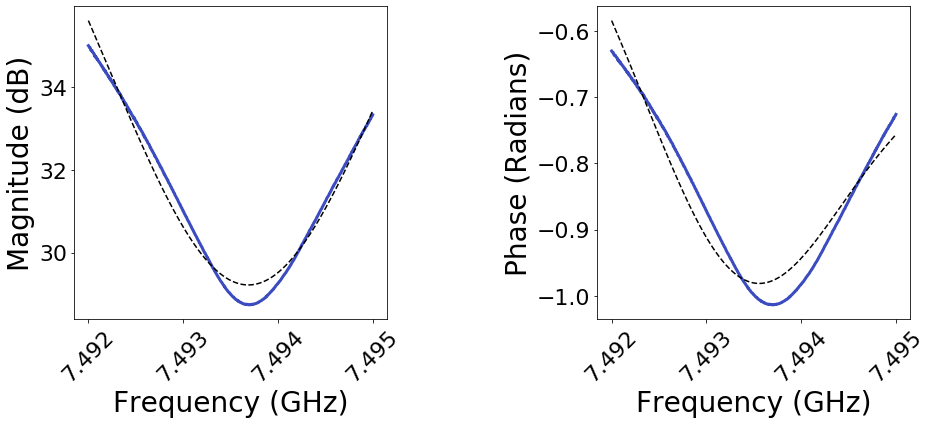

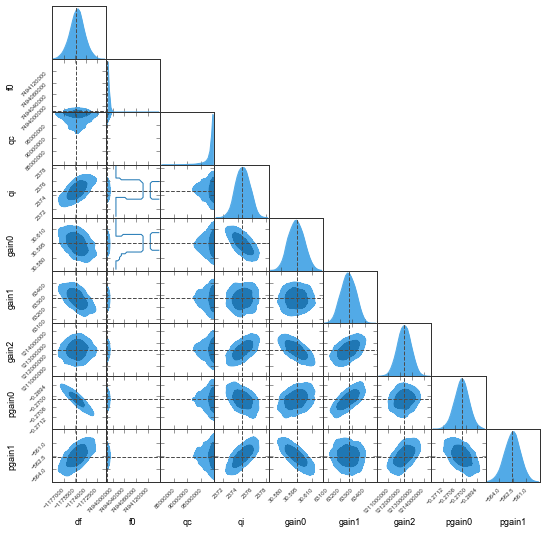

In [51]:
def __main__():
    wrap = ScrapsWrapper()

    #Load in a file
#     dataFile = '../data/ADS-1_-80_DBM_TEMP_1.602.S2P'
#     pkl_file = '../data/b0mt'
    dataFile = '../data/ResI_-20_DBM_TEMP_1.602.S2P'
#     wrap.pkl_to_s2p(pkl_file,dataFile)
    
    #Use the process_file routine to read the file and create a dict of resonator data
    fileDataDict = wrap.process_file(dataFile, skiprows=1)

    #Look at the contents of the dict:
    pp.pprint(fileDataDict)
    
    fileDataDict['I'] = -1*fileDataDict['I']
    fileDataDict['I'] = 10**(fileDataDict['I']/20)
    
    resObj1,resObj2 = wrap.resonator_objects(fileDataDict)
    
    wrap.plot_ResListData(resObj2)
    
    chains = wrap.do_emcee(resObj2)
    
    wrap.plot_gtc(resObj2,chains)
    
if __name__ == "__main__":
    __main__()

Temperature =  1.602
Power =  -80.0
Do fit results exist for the first object?  False
Do fit results exist for the second object?  True
Do fit results exist for the first object?  True
Do fit results exist for the second object?  True
Guess =  9500000000.0  Hz
Best fit =  9499993453.393993  Hz
Best fit with different qc guess =  9499987870.107874  Hz


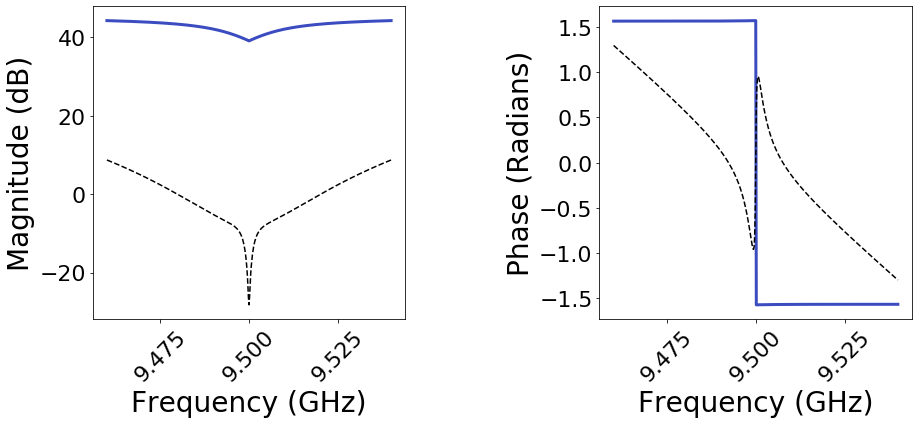

In [49]:
wrap = ScrapsWrapper()

#Load in a file
dataFile = '../data/ADS-2_-80_DBM_TEMP_1.602.S2P'

#Use the process_file routine to read the file and create a dict of resonator data
fileDataDict = wrap.process_file(dataFile, skiprows=1)

# fileDataDict['I'] = -20*np.log10(fileDataDict['I'])
# fileDataDict['I'] = -1*fileDataDict['I'] + min(-1*fileDataDict['I'])

#Look at the contents of the dict:
# pp.pprint(fileDataDict)

resObj1,resObj2 = wrap.resonator_objects(fileDataDict)

wrap.plot_ResListData(resObj2)

# chains = wrap.do_emcee(resObj2)

# wrap.plot_gtc(resObj2,chains)

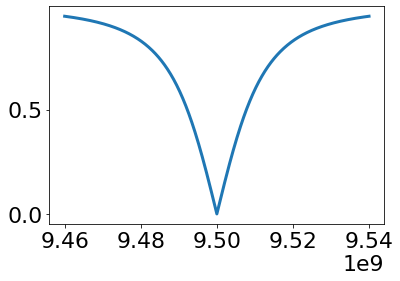

In [50]:
plt.plot(fileDataDict['freq'],fileDataDict['I'])
# plt.plot(fileDataDict['freq'],fileDataDict['Q'])

In [38]:
min(-1*fileDataDict['I'])

-0.7662646336602615